TODO:
* Add weight sharing model
* Make model more sophisticated
* Look and analize where models fail

## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2 ×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy

from dlc_practical_prologue import generate_pair_sets

## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [2]:
N = 1000

In [3]:
train_input, train_class, train_digit, test_input, test_class, test_digit = generate_pair_sets(N)

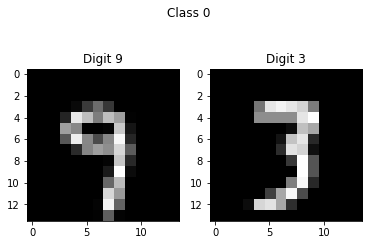

In [4]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Digit {train_digit[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Digit {train_digit[0][1].item()}")
fig.suptitle(f"Class {train_class[0].item()}")

plt.show()

In [5]:
train_loader = DataLoader(list(zip(train_input, train_class, train_digit)), batch_size=64)
test_loader = DataLoader(list(zip(test_input, test_class, test_digit)), batch_size=64)

## Objective

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest.

In [6]:
cross_entropy = nn.CrossEntropyLoss()
binary_cross_entropy = nn.BCEWithLogitsLoss()

## Model

In [7]:
input_channels = 2
output_class_channels = 2
output_digit_channels = 10

### Simple model

First let's implement simple model

In [8]:
class NetSimple(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 2 * 2, 50)
        self.fc2 = nn.Linear(50, output_channels)
        
        self.predicts_digit = False

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        output_class = self.forward(x)
        _, predicted_class = torch.max(output_class, 1)
        return predicted_class

In [9]:
net = NetSimple(input_channels, output_class_channels)

In [10]:
def simple_model_criterion(output, target):
    return cross_entropy(output, target)

In [11]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 12, 12]             114
         MaxPool2d-2              [-1, 6, 6, 6]               0
            Conv2d-3             [-1, 16, 4, 4]             880
         MaxPool2d-4             [-1, 16, 2, 2]               0
            Linear-5                   [-1, 50]           3,250
            Linear-6                    [-1, 2]             102
Total params: 4,346
Trainable params: 4,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### Model with weight sharing (Siamese network)

### Model with auxiliary loss

In [12]:
class NetAuxiliaryLoss(nn.Module):
    def __init__(self, input_channels, output_class_channels, output_digit_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 2 * 2, 50)
        self.fc2 = nn.Linear(50, output_class_channels)
        self.fc3 = nn.Linear(50, output_digit_channels)
        self.fc4 = nn.Linear(50, output_digit_channels)
        self.predicts_digit = True

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 2 * 2)
        x = F.relu(self.fc1(x))
        output_class = self.fc2(x)
        output_digit1 = self.fc3(x)
        output_digit2 = self.fc4(x)
        return output_class, [output_digit1, output_digit2]
    
    def predict(self, x):
        output_class, output_digits = self.forward(x)
        _, predicted_class = torch.max(output_class, 1)
        _, predicted_digit1 = torch.max(output_digits[0], 1)
        _, predicted_digit2 = torch.max(output_digits[1], 1)
        return predicted_class, [predicted_digit1, predicted_digit2]

In [13]:
net = NetAuxiliaryLoss(input_channels, output_class_channels, output_digit_channels)

In [14]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 12, 12]             114
         MaxPool2d-2              [-1, 6, 6, 6]               0
            Conv2d-3             [-1, 16, 4, 4]             880
         MaxPool2d-4             [-1, 16, 2, 2]               0
            Linear-5                   [-1, 50]           3,250
            Linear-6                    [-1, 2]             102
            Linear-7                   [-1, 10]             510
            Linear-8                   [-1, 10]             510
Total params: 5,366
Trainable params: 5,366
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [15]:
def auxiliary_loss_criterion(output_class, target_class, output_digits, target_digits):
    return cross_entropy(output_class, target_class) \
            + cross_entropy(output_digits[0], target_digits[:, 0]) \
            + cross_entropy(output_digits[0], target_digits[:, 1])

## Training

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
def get_accuracy(model, data_loader, calculate_accuracy_digit=False):
    """Calculates accuracy of predicting class or predicting class and digit of model on data from data_loader"""
    if calculate_accuracy_digit:
        return get_accuracy_class_and_digit(model, data_loader)
    else:
        return get_accuracy_class(model, data_loader)
    
def get_accuracy_class(model, data_loader):
    """Calculates accuracy of predicting class of model on data from data_loader"""
    correct_class = 0
    total = 0
    
    for (image, class_target, digit_target) in data_loader:
        predicted_class = model.predict(image)
        correct_class += (predicted_class == class_target).sum().item()
        total += len(class_target)
        
    accuracy = correct_class / total
    return accuracy

def get_accuracy_class_and_digit(model, data_loader):
    """Calculates accuracy of predicting class and digit of model on data from data_loader"""
    correct_class = 0
    correct_digit = 0
    total = 0
    
    for (image, class_target, digit_target) in data_loader:
        predicted_class, (predicted_digit1, predicted_digit2) = model.predict(image)
        correct_class += (predicted_class == class_target).sum().item()
        correct_digit += (predicted_digit1 == digit_target[:, 0]).sum().item()
        correct_digit += (predicted_digit2 == digit_target[:, 1]).sum().item()
        total += len(class_target)
        
    accuracy_class = correct_class / total
    accuracy_digit = correct_digit / total / 2
    return accuracy_class, accuracy_digit

In [18]:
def train(train_data_loader, test_data_loader,
          model, optimizer, criterion,
          epochs=10, print_info=False, print_every=5):
    """Trains model and computes accuracy on each test_every steps"""
    
    losses = []
    # Accuracy of class prediction
    accuracy_train_class = []
    accuracy_test_class = []
    # Accuracy of digit precition for model with auxiliary loss
    accuracy_train_digit = []
    accuracy_test_digit = []
    # Early stopping (saving the best model among epochs)
    best_model = None
    best_accuracy = 0
    
    for epoch in range(epochs):
        loss_epoch = 0
        
        # Train
        for (image, target_class, target_digits) in train_data_loader:
            optimizer.zero_grad()
            if model.predicts_digit: # For model with auxiliary loss
                output_class, output_digits = model(image)
                loss = criterion(output_class, target_class, output_digits, target_digits)
            else:
                output_class = model(image)
                loss = criterion(output_class, target_class)
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
                
        losses.append(loss_epoch)
        
        # Test
        model.eval()
        with torch.no_grad():
            accuracy_train_data = get_accuracy(model, train_data_loader,
                                               calculate_accuracy_digit=model.predicts_digit)
            accuracy_test_data = get_accuracy(model, test_data_loader,
                                              calculate_accuracy_digit=model.predicts_digit)

            if model.predicts_digit: # For model with auxiliary loss
                acc_train_class, acc_train_digit = accuracy_train_data
                acc_test_class, acc_test_digit = accuracy_test_data

                accuracy_train_digit.append(acc_train_digit)
                accuracy_test_digit.append(acc_test_digit)
            else:
                acc_train_class = accuracy_train_data
                acc_test_class = accuracy_test_data

            accuracy_train_class.append(acc_train_class)
            accuracy_test_class.append(acc_test_class)
    
        if accuracy_test_class[-1] > best_accuracy:
            best_model = copy.deepcopy(model)
            
        if print_info and (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs}, loss {losses[-1]:0.4f},",
                  f"class train/test accuracy: {accuracy_train_class[-1]}/{accuracy_test_class[-1]}",
                  f", digit train/test accuracy: {accuracy_train_digit[-1]}/{accuracy_test_digit[-1]}"
                  if accuracy_train_digit else "")
        
    return model, [accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit], losses

In [19]:
def grid_search(learning_rates, regularizations, 
                train_data_loader, test_data_loader, 
                model_class, model_params, criterion, 
                epochs=20, print_info=False):
    """Grid search for tuning hyperparameters (regularization term and learning rate)"""
    config_accuracy = [] # Test accuracies for different configurations 
    for lr in learning_rates:
        for reg in regularizations:
            model = model_class(**model_params)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
            
            _, accuracies, _ = train(train_loader, test_loader,
                                model=model,
                                optimizer=optimizer, 
                                criterion=criterion,
                                epochs=epochs)
            
            _, accuracy_test_class, _, _ = accuracies
            config_accuracy.append([lr, reg, max(accuracy_test_class)])
            if print_info:
                print(f"Learning rate: {lr:0.4f}, Regularization: {reg:0.2f}, Test Accuracy: {max(accuracy_test_class):0.3f}")
    
    config_accuracy.sort(key=lambda x: x[2], reverse=True)
    best_config = config_accuracy[0]
    lr, reg = best_config[:2]
    if print_info:
        print(f"Best configuration: learning rate = {lr}, regularization = {reg}")
    return lr, reg

In [20]:
def plot_accuracy_and_loss(accuracy_train, accuracy_test, losses, title):
    """Plot accuracy and loss curves"""
    fig, ax1 = plt.subplots()

    color_tr = 'tab:green'
    color_val = 'tab:blue'
    ax1.set_xlabel("Step (x100)")
    ax1.set_ylabel("Accuracy (train - green, validation - blue)")
    ax1.plot(range(len(accuracy_train)), accuracy_train, color=color_tr)
    ax1.plot(range(len(accuracy_test)), accuracy_test, color=color_val)
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color_loss = 'tab:red'
    ax2.set_ylabel("Loss", color=color_loss)  # we already handled the x-label with ax1
    ax2.plot(range(len(losses)), losses, color=color_loss)
    ax2.tick_params(axis='y', labelcolor=color_loss)

    fig.tight_layout()
    plt.title(title)
    plt.grid()
    plt.show()

In [21]:
def test_samples(model, nb_tests=5):
    """Test model on random samples from test dataset"""
    indices_to_test = (torch.rand(nb_tests) * len(test_input)).int()

    for ind in indices_to_test:
        image = test_input[ind]
        target_class = test_class[ind]
        target_digit = test_digit[ind]

        if model.predicts_digit:
            predicted_class, predicted_digits = model.predict(image.unsqueeze(0))
        else:
            predicted_class = model.predict(image.unsqueeze(0))

        fig, axs = plt.subplots(1, 2)
        for i in range(2):
            axs[i].imshow(image[i], cmap="gray")
            title = f"Digit: {target_digit[i].item()}" + \
            (f", predicted: {predicted_digits[i].item()}" if model.predicts_digit else "")
            axs[i].set_title(title)
        
        fig.suptitle(f"Class: {target_class.item()}, predicted: {predicted_class.item()}")

        plt.show()

#### Simple net

In [22]:
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels}

lr, reg = grid_search([0.05, 0.01, 0.005, 0.001], # Learning rates
                      [0.1, 0.5, 0.7, 1, 1.5], # Regularizations
                      train_loader, test_loader, 
                      NetSimple, model_params, simple_model_criterion, 
                      epochs=40, print_info=True)

Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.713
Learning rate: 0.0500, Regularization: 0.50, Test Accuracy: 0.673
Learning rate: 0.0500, Regularization: 0.70, Test Accuracy: 0.536
Learning rate: 0.0500, Regularization: 1.00, Test Accuracy: 0.616
Learning rate: 0.0500, Regularization: 1.50, Test Accuracy: 0.526
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.765
Learning rate: 0.0100, Regularization: 0.50, Test Accuracy: 0.799
Learning rate: 0.0100, Regularization: 0.70, Test Accuracy: 0.531
Learning rate: 0.0100, Regularization: 1.00, Test Accuracy: 0.526
Learning rate: 0.0100, Regularization: 1.50, Test Accuracy: 0.526
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.785
Learning rate: 0.0050, Regularization: 0.50, Test Accuracy: 0.805
Learning rate: 0.0050, Regularization: 0.70, Test Accuracy: 0.784
Learning rate: 0.0050, Regularization: 1.00, Test Accuracy: 0.745
Learning rate: 0.0050, Regularization: 1.50, Test Accuracy: 0.713
Learning r

In [23]:
epochs = 40
net_simple = NetSimple(input_channels, output_class_channels)

net_simple, accuracies, losses = train(train_loader, test_loader,
                                       model=net_simple,
                                       optimizer=optim.Adam(net_simple.parameters(), lr=lr, weight_decay=reg), 
                                       criterion=simple_model_criterion,
                                       epochs=epochs, print_info=True)

accuracy_train_class, accuracy_test_class, _, _ = accuracies

Epoch 5/40, loss 8.1004, class train/test accuracy: 0.785/0.72 
Epoch 10/40, loss 7.2686, class train/test accuracy: 0.811/0.77 
Epoch 15/40, loss 6.7229, class train/test accuracy: 0.852/0.783 
Epoch 20/40, loss 6.5336, class train/test accuracy: 0.83/0.761 
Epoch 25/40, loss 6.1169, class train/test accuracy: 0.856/0.763 
Epoch 30/40, loss 6.0037, class train/test accuracy: 0.857/0.776 
Epoch 35/40, loss 5.8659, class train/test accuracy: 0.852/0.763 
Epoch 40/40, loss 5.8748, class train/test accuracy: 0.862/0.777 


In [24]:
net_simple_filename = "net_simple.ckpt"
torch.save(net_simple.state_dict(), net_simple_filename)

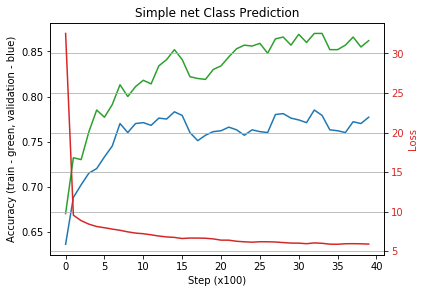

In [25]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="Simple net Class Prediction")

#### Auxiliary loss

In [26]:
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels}

lr, reg = grid_search([0.05, 0.01, 0.005, 0.001], # Learning rates
                      [0.1, 0.5, 0.7, 1, 1.5], # Regularizations
                      train_loader, test_loader, 
                      NetAuxiliaryLoss, model_params, auxiliary_loss_criterion, 
                      epochs=40, print_info=True)

Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.526
Learning rate: 0.0500, Regularization: 0.50, Test Accuracy: 0.526
Learning rate: 0.0500, Regularization: 0.70, Test Accuracy: 0.597
Learning rate: 0.0500, Regularization: 1.00, Test Accuracy: 0.528
Learning rate: 0.0500, Regularization: 1.50, Test Accuracy: 0.526
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.804
Learning rate: 0.0100, Regularization: 0.50, Test Accuracy: 0.729
Learning rate: 0.0100, Regularization: 0.70, Test Accuracy: 0.541
Learning rate: 0.0100, Regularization: 1.00, Test Accuracy: 0.536
Learning rate: 0.0100, Regularization: 1.50, Test Accuracy: 0.592
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.770
Learning rate: 0.0050, Regularization: 0.50, Test Accuracy: 0.781
Learning rate: 0.0050, Regularization: 0.70, Test Accuracy: 0.810
Learning rate: 0.0050, Regularization: 1.00, Test Accuracy: 0.764
Learning rate: 0.0050, Regularization: 1.50, Test Accuracy: 0.628
Learning r

In [27]:
epochs = 40
net_auxiliary_loss = NetAuxiliaryLoss(input_channels, output_class_channels, output_digit_channels)

net_auxiliary_loss, accuracies, losses = train(train_loader, test_loader,
                                               model=net_auxiliary_loss,
                                               optimizer=optim.Adam(net_auxiliary_loss.parameters(), lr=lr, weight_decay=reg), 
                                               criterion=auxiliary_loss_criterion,
                                               epochs=epochs, print_info=True)

accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies

Epoch 5/40, loss 78.9087, class train/test accuracy: 0.666/0.661 , digit train/test accuracy: 0.134/0.136
Epoch 10/40, loss 67.6176, class train/test accuracy: 0.679/0.689 , digit train/test accuracy: 0.224/0.202
Epoch 15/40, loss 58.4429, class train/test accuracy: 0.729/0.727 , digit train/test accuracy: 0.248/0.2305
Epoch 20/40, loss 55.2594, class train/test accuracy: 0.804/0.768 , digit train/test accuracy: 0.2375/0.2165
Epoch 25/40, loss 54.0778, class train/test accuracy: 0.786/0.77 , digit train/test accuracy: 0.247/0.23
Epoch 30/40, loss 51.9490, class train/test accuracy: 0.828/0.777 , digit train/test accuracy: 0.253/0.2375
Epoch 35/40, loss 50.6639, class train/test accuracy: 0.845/0.795 , digit train/test accuracy: 0.252/0.237
Epoch 40/40, loss 49.8948, class train/test accuracy: 0.838/0.797 , digit train/test accuracy: 0.2575/0.233


In [28]:
net_auxiliary_loss_filename = "net_auxiliary_loss.ckpt"
torch.save(net_auxiliary_loss.state_dict(), net_auxiliary_loss_filename)

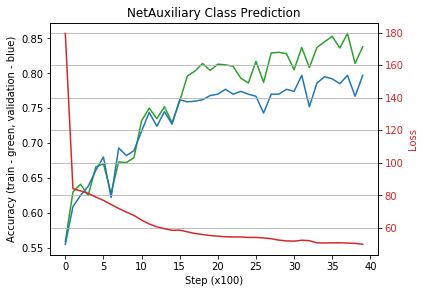

In [29]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="NetAuxiliary Class Prediction")

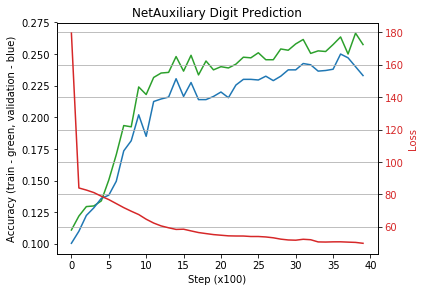

In [30]:
plot_accuracy_and_loss(accuracy_train_digit, accuracy_test_digit, losses, title="NetAuxiliary Digit Prediction")

### Test

#### Simple net

In [31]:
checkpoint = torch.load(net_simple_filename)
net_simple = NetSimple(input_channels, output_class_channels)
net_simple.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

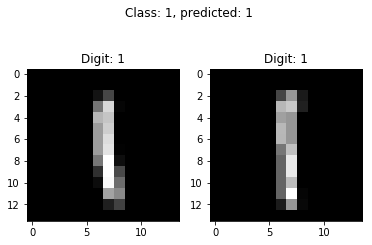

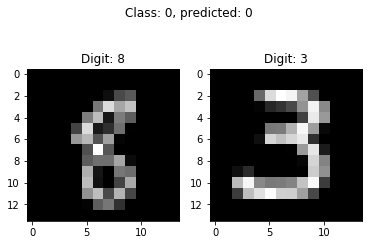

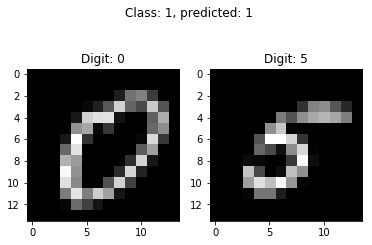

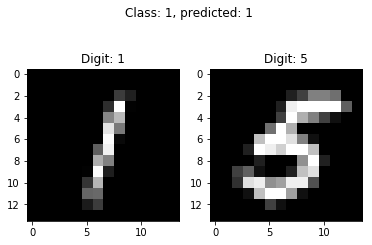

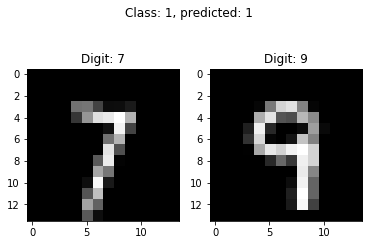

In [32]:
test_samples(net_simple)

#### Weight sharing (Siamese network)

#### Auxiliary loss

In [33]:
checkpoint = torch.load(net_auxiliary_loss_filename)
net_auxiliary_loss = NetAuxiliaryLoss(input_channels, output_class_channels, output_digit_channels)
net_auxiliary_loss.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

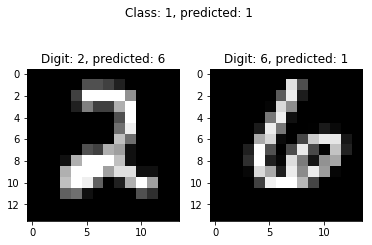

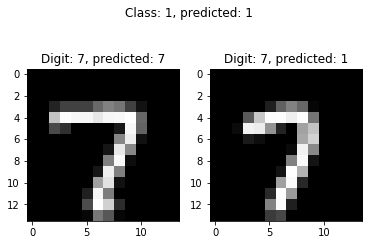

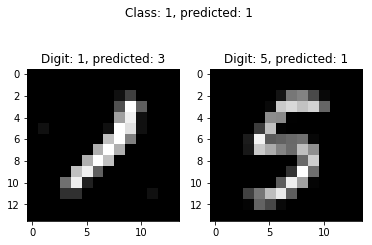

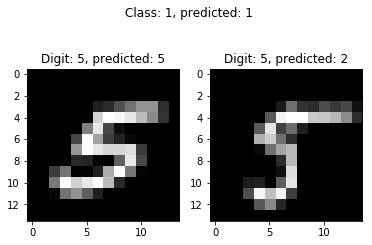

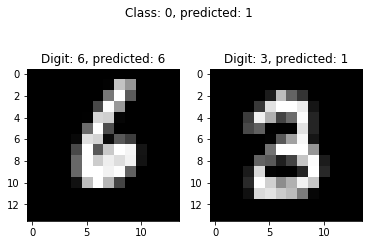

In [34]:
test_samples(net_auxiliary_loss)

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.